In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFCS_emimTF2N_PR import configuration

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [7]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(320)
m.fs.F101.inlet.pressure.fix(500000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(298)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [8]:
m.fs.F101.initialize(outlvl=idaeslog.INFO_HIGH)

2021-03-22 15:27:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: Starting initialization
2021-03-22 15:27:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solution Found.
2021-03-22 15:27:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: Equilibrium temperature initialization completed.
2021-03-22 15:27:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: State variable initialization completed.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
2021-03-22 15:27:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: Phase equilibrium initialization: infeasible - Converged to a locally infeasible point. Problem may be infeasible..
2021-03-22 15:27:39 [INFO] idaes.init.fs.F101.control_volume.properties_in: Property initialization: optimal - Optimal Sol

In [9]:
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [10]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value       : Fixed : Bounds
          Heat Duty : -2.9570e+09 : False : (None, None)
    Pressure Change :      0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    1.0000      0.99956     0.0014389  
    mole_frac_comp emimTf2N  0.0010000   1.0000e-08       0.69500  
    mole_frac_comp R32         0.50000      0.49997       0.17307  
    mole_frac_comp R125        0.50000      0.50003       0.13193  
    temperature                 320.00       298.00        298.00  
    pressure                5.0000e+05   5.0000e+05    5.0000e+05  


In [17]:
IL_z = np.linspace(0.99, 0.01, 10)
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

for j in range(len(IL_z)):

    fract = 1 - IL_z[j]
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.7*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.3*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(IL_z[j])   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        print(value(m.fs.F101.liq_outlet.flow_mol[0]))
        print(value(m.fs.F101.vap_outlet.flow_mol[0]))
    else:
        print('Infeasible.')

    

    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
    model.name="Simp

In [18]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [0.         0.88111111 0.77222223 0.68443755 0.68286226 0.68193514
 0.681327   0.68089815 0.68057979 0.68033422]
IL_y = [0.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
R32_x = [0.         0.08322222 0.15944444 0.22264798 0.22986697 0.23409518
 0.23686053 0.23880667 0.24024936 0.24136101]
R32_y = [0.         0.63720924 0.63721752 0.64486135 0.66601887 0.67841814
 0.68653039 0.69224083 0.69647472 0.69973752]
R125_x = [0.         0.03566667 0.06833333 0.09291448 0.08727077 0.08396968
 0.08181248 0.08029518 0.07917085 0.07830477]
R125_y = [0.         0.36279076 0.36278248 0.35513865 0.33398113 0.32158186
 0.31346961 0.30775917 0.30352528 0.30026248]


In [19]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
print(points_y)

[(0.0, 0.0, 0.0), (0.8811111122051064, 0.08322222153438708, 0.0356666662605065), (0.7722222314037995, 0.1594444387638123, 0.06833332983238818), (0.6844375453416611, 0.22264797619996285, 0.09291447845837593), (0.682862259502207, 0.2298669676443588, 0.08727077285343415), (0.6819351448963811, 0.2340951766534412, 0.08396967845017768), (0.6813269957944146, 0.23686052625619633, 0.08181247794938913), (0.680898152054516, 0.23880667273426745, 0.08029517521121657), (0.6805797944326821, 0.24024935637960648, 0.0791708491877115), (0.6803342221682043, 0.24136100534836033, 0.07830477248343545)]
[(0.0, 0.0, 0.0), (1e-08, 0.6372092376007292, 0.3627907623992707), (1e-08, 0.6372175151167414, 0.3627824848832586), (1e-08, 0.6448613496761915, 0.3551386503238084), (1e-08, 0.6660188710586836, 0.3339811289413164), (1e-08, 0.6784181356433819, 0.321581864356618), (1e-08, 0.6865303930001111, 0.31346960699988896), (1e-08, 0.6922408336357306, 0.30775916636426937), (1e-08, 0.6964747164557813, 0.30352528354421876), (

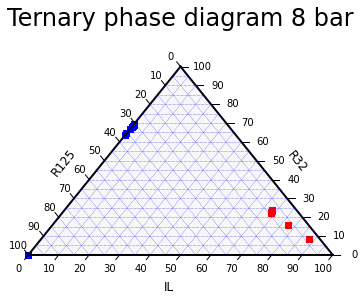

In [21]:
points_x = []

for i in range(0,9):
    points = (IL_x[i]*100, R32_x[i]*100, R125_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(0,9):
    points = (IL_y[i]*100, R32_y[i]*100, R125_y[i]*100)
    points_y.append(points)

import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R125", fontsize=fontsize, offset=offset)
tax.right_axis_label("R32", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

for i in range(1):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

tax.scatter(points_x, marker='s', color='red', label="liquid")
tax.scatter(points_y, marker='s', color='blue', label="vapor")


tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()